In [1]:
#Azimuthal Average Codes For Dean

#Import packages (more than needed here)
import os
import glob
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4
from netCDF4 import Dataset
import numpy as np
import math
from numpy import *
from pylab import *
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
import matplotlib.patches as mpatches

#Stuff for Meteorological calculations 
import wrf
import metpy.calc as mpcalc
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [2]:
#First, Specifiy File path
filepath = '/Users/cjmasiel/Desktop/unadjusted/wrfout_d02_2007-08-21_08:00:00'

# Name of subdirectory (or full path) to where your data files are located
datafiles = sorted(glob.glob(filepath))

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def wind():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/160, "#000000"), 
    (34/160, "#a6a6a6"),
    (34/160, "#4245a6"),
    (64/160, "#29a668"),
    (96/160, "#cccc33"),
    (113/160, "#cc3333"),
    (137/160, "#cc7acc"),
    (160/160, "#ffffff")])

    return newcmp

In [4]:
#Let's consider the point right before landfall, so the 19th data point


# set some constants for later use
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50

Number of Pressure levels in the vertical 39
WRF valid time:  2007-08-21_08 2007-08-21 08:00 2007-08-21T08:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_79609/1531105011.py:139: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_79609/1531105011.py:140: RuntimeWarning: Mean of empty slice
  wsazavg[k,bincnt] = np.nanmean(wsbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_79609/1531105011.py:143: RuntimeWarning: Mean of empty slice
  urazavg[k,bincnt] = np.nanmean(urbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_79609/1531105011.py:144: RuntimeWarning: Mean of empty slice
  vaazavg[k,bincnt] = np.nanmean(vabin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_79609/1531105011.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_79609/1531105011.py:159: UserWarning: FixedFormatter should only be used together with Fixed

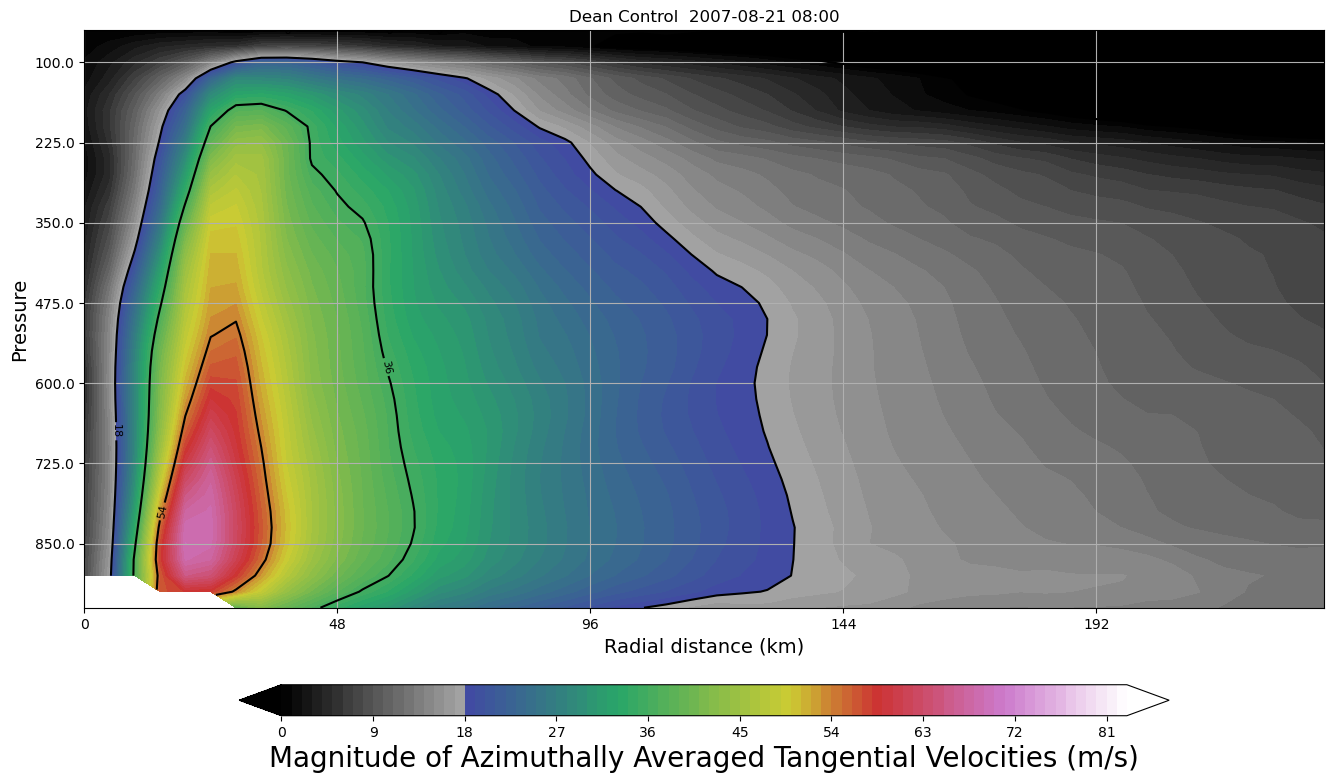

In [5]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000.,97500.,95000.,92500.,90000.,87500.,85000.,82500.,80000.,77500.,75000.,72500.,70000.,67500.,65000.,62500.,60000.,
           57500.,55000.,52500.,50000.,47500.,45000.,42500.,40000.,37500.,35000.,32500.,30000.,27500.,25000.,22500.,20000.,17500.,
           15000.,12500.,10000., 7500., 6000.]

nlevs  = len(plevs)
print("Number of Pressure levels in the vertical", nlevs)
yplabs = ['']*nlevs

for j in range(0,1):                    #we are only interested in the 19th element of our datafiles
    ncfile = Dataset(datafiles[j])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime, titletime, timestr)
    # get constant variables
    lats = getvar(ncfile, "XLAT")
    lons = getvar(ncfile, "XLONG") 
    land = getvar(ncfile, "LANDMASK")
    ptop = getvar(ncfile, "P_TOP")

    nx = lats.shape[0]
    ny = lats.shape[1]
    ##print(nx,ny)
    ##print(ptop.values)

    # Initialize subset arrays with zero values. Start with field variables, then diagnostics
    hght, tmpk, ugrd, vgrd, omeg, relh, refl = [np.zeros([nx,ny,nlevs]) for _ in range(7)]  #Range is just the number of variables specified to the left
    ht3,  tk3,  ua3,  va3, wa3, rh3, rf3     = [np.zeros([nx,ny,nlevs]) for _ in range(7)]
    dthtadp, dudp,  dvdp, dudy, dvdx         = [np.zeros((nx,ny,nlevs)) for _ in range(5)]
    dthdx,   dthdy, rvor, avor, pvor, pvw    = [np.zeros((nx,ny,nlevs)) for _ in range(6)]
    thta,  tlcl, thte, dthtedp      = [np.zeros((nx,ny,nlevs)) for _ in range(4)]
    lt, ln, ltf, lnf, fcor   = [np.zeros((nx,ny)) for _ in range(5)]
    
    # Get variables 
    z = getvar(ncfile, "z")
    p = getvar(ncfile, "pressure")
    slp = getvar(ncfile, "slp")
    tk = getvar(ncfile, "tk")
    ua = getvar(ncfile, "ua")
    va = getvar(ncfile, "va")
    rh = getvar(ncfile, "rh")
    wa  = getvar(ncfile, "wa")
    pvo = getvar(ncfile, "pvo")
    rainc = getvar(ncfile, "RAINC")
    rainnc = getvar(ncfile, "RAINNC")
    psfc = getvar(ncfile, "PSFC")

    for k in range (nlevs):
        clev = plevs[k]/100.
        yplabs[k] = clev
        ##print('interpolating to: ',clev)
        
        # Do vertical interpolation to specified pressure surfaces (in hPa)
        htp = interplevel(z, p, clev)
        uap = interplevel(ua, p, clev)
        vap = interplevel(va, p, clev)
        wap = interplevel(wa, p, clev)
        tkp = interplevel(tk, p, clev)
        rhp = interplevel(rh, p, clev)
        pvp = interplevel(pvo, p, clev)
    
        # Smoothing factor
        smfac = 3   # light smoothing, none for reflectivity
        hght[:,:,k] = mpcalc.smooth_gaussian(htp[:,:],smfac)
        tmpk[:,:,k] = mpcalc.smooth_gaussian(tkp[:,:],smfac)
        ugrd[:,:,k] = mpcalc.smooth_gaussian(uap[:,:],smfac)
        vgrd[:,:,k] = mpcalc.smooth_gaussian(vap[:,:],smfac)
        wa3[:,:,k] = mpcalc.smooth_gaussian(wap[:,:],smfac)
        relh[:,:,k] = mpcalc.smooth_gaussian(tkp[:,:],smfac)
    
    wrf_out_data = xr.open_dataset(datafiles[j])   

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    #print(surface_P_pertubation)
    
    minpressure = np.min(surface_P_pertubation[:,:])
    minp = minpressure.values

    #Now we know what the lowest pressure is, we have to find the index value for where it occurs
    da = surface_P_pertubation
    p_index = np.argwhere(da.where(da == minp,0).values)
    s_n = p_index[0][0]
    w_e = p_index[0][1]
    
    # Azimuthal average by binning.  Need to specify grid point of storm center, and have arrays for lat, lon
    # Could also set up to specify lat/lon of storm center
    binnum  = 50
    binsize = 1
    dx      = 12000.
    ydist, xdist, tcdist, rlonfac                              = [np.zeros([nx,ny]) for _ in range(4)]
    pvbin, wabin, wsbin, thbin, rfbin, urbin, vabin, theta_ang = [np.zeros([nx,ny]) for _ in range(8)]
    u_radial, v_azimuth, windabs                               = [np.zeros([nx,ny,nlevs]) for _ in range(3)]
    
    thavg =np.zeros(nlevs)
    xlabs = ['']*binnum
    pvazavg, waazavg, thazavg, wsazavg, rfazavg, urazavg, vaazavg = [np.zeros([nlevs-1,int(binnum/binsize)]) for _ in range(7)]

    # define storm center
    ypos = s_n
    xpos = w_e

    # compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*cos(d2r*lats[:,:])
    ydist[:,:]   = (lats[:,:] - lats[ypos,xpos])*111000
    xdist[:,:]   = (lons[:,:] - (lons[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    windabs[:,:,:] = sqrt(ugrd[:,:,:]**2 + vgrd[:,:,:]**2)
    for k in range (1,nlevs-1):
        thavg[k] = np.nanmean(thta[:,:,k])

    for k in range (0,nlevs):
        thavg[k] = np.nanmean(thta[:,:,k])
        for i in range (0,nx):
            for j in range (0,ny):
                theta_ang[i,j] = math.atan2(ydist[i,j],xdist[i,j])
                u_radial[i,j,k] = ugrd[i,j,k]*math.cos(theta_ang[i,j]) + vgrd[i,j,k]*math.sin(theta_ang[i,j])
                v_azimuth[i,j,k] = -ugrd[i,j,k]*sin(theta_ang[i,j]) + vgrd[i,j,k]*cos(theta_ang[i,j])         

    for j in range (0, binnum, binsize):
        binmin = j*dx
        binmax = (j+binsize)*dx
        bincnt = int(j/binsize)
        #print(binmin, binmax, bincnt)
        xlabs[j] = str(bincnt*12)
        for k in range (1, nlevs-1):
            #pvbin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), pvor[:,:,k], nan)
            wabin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), wa3[:,:,k], nan)
            wsbin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), windabs[:,:,k], nan)
            thbin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), thta[:,:,k], nan)
            rfbin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), refl[:,:,k], nan)
            urbin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), u_radial[:,:,k], nan)
            vabin[:,:] = np.where( ((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), v_azimuth[:,:,k], nan)
            #pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
            waazavg[k,bincnt] = np.nanmean(wabin[:,:])
            wsazavg[k,bincnt] = np.nanmean(wsbin[:,:])
            thazavg[k,bincnt] = np.nanmean(thbin[:,:]) - thavg[k]
            rfazavg[k,bincnt] = np.nanmean(rfbin[:,:])
            urazavg[k,bincnt] = np.nanmean(urbin[:,:])
            vaazavg[k,bincnt] = np.nanmean(vabin[:,:])
       
    # Try plotting with pressure on ordinate, radial distance on abscissa, and overlaying contours and shading
    # Note:  Check that vertical levels are matched correctly!! 
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    import matplotlib.ticker as ticker
    fig = plt.figure(figsize=(16, 10))

    ax = fig.add_subplot(1, 1, 1)

    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    ylabels[:] = yplabs[1::5]
    ax.set_yticklabels(ylabels)
    xlabels = [item.get_text() for item in ax.get_yticklabels()]
    xlabels = xlabs[0::4]
    ax.set_xticklabels(xlabels)

    ax.set_xlabel('Radial distance (km)', fontsize=14)
    ax.set_ylabel('Pressure', fontsize=14)
    ax.set_title('Dean Control  '+titletime)
    ax.grid(True)

    radial = np.arange(0,binnum)
    vertical = np.arange(1,nlevs-1)
    
    contours = plt.contour(radial, vertical, vaazavg[1:nlevs-1,:], levels = np.arange(0,90,18), colors='black', origin='lower')
    plt.clabel(contours, inline=True, fontsize=8, fmt='%2.0f')

    plot = plt.contourf(radial, vertical, vaazavg[1:nlevs-1,:], origin = 'lower', levels = np.arange(0,84,1), cmap = wind(), extend='both')
    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .1, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('Magnitude of Azimuthally Averaged Tangential Velocities (m/s)', fontsize = 20)
    
#     #Save Plots to Designated Directory
#     outTPlotName= 'urazavg'+filetime+'.png'
#     plt.savefig(plotsdir+outTPlotName)
#     plt.close()